In [1]:
import torch
import torch.nn as nn
import numpy as np
from utils.utils import load_data_set, gen_batch_sequence
from model.wordEmbedding import WordEmbedding

from tqdm import tqdm
import gc
from datetime import datetime
import matplotlib.pyplot as plt
from types import GeneratorType

In [3]:
# TODO: add this to utils function
def create_toy_dataset(actual_queries, table_data, num_samples):
    idx_list = np.random.permutation(len(actual_queries))[:num_samples]
    toy_queries = list(actual_queries[x] for x in idx_list)
    toy_tables = {}
    for x in range(num_samples):
        toy_tables[toy_queries[x]['table_id']] = table_data[toy_queries[x]['table_id']]
    return toy_queries, toy_tables

#sample_queries, sample_tables = create_toy_dataset(train_queries,train_table,500)


In [4]:
train_query, train_table = load_data_set('train')

Loading train dataset
Loaded 56355 queries and 18585 tables


In [5]:
selected_query_id = [34,56,12,43] #random
ret_tup = gen_batch_sequence(train_query,train_table,selected_query_id, 0, len(selected_query_id))

In [6]:
batch_query = ret_tup[0]
batch_table = ret_tup[1]
gt_quety = ret_tup[4]
print(batch_query)

[['during', 'which', 'years', 'was', 'marcus', 'banks', 'in', 'toronto', '?'], ['what', 'is', 'the', 'canton', 'of', 'grande', 'dixence', '?'], ['what', 'school', 'did', 'player', 'number', '6', 'come', 'from', '?'], ['what', 'time', 'was', 'the', 'highest', 'for', '2nd', 'finishers', '?']]


In [7]:
word_emb = WordEmbedding('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [8]:
print(word_emb.bert_model.config.hidden_size)

768


In [9]:
q_seq, col_seq, col_num, ans_seq, query_seq, ground_truth_cond_seq, raw_data = \
        gen_batch_sequence(train_query, train_table,selected_query_id,0,len(selected_query_id))
print(raw_data)

[('During which years was Marcus Banks in Toronto?', ['Player', 'No.', 'Nationality', 'Position', 'Years in Toronto', 'School/Club Team'], 'SELECT years in toronto FROM table_ WHERE player EQL marcus banks'), ('What is the canton of grande dixence?', ['Name', 'Canton', 'Height (meters)', 'Crest length (meters)', 'Type', 'Year of construction', 'Name of the Lake'], 'SELECT canton FROM table_ WHERE name EQL grande dixence'), ('What school did player number 6 come from?', ['Player', 'No.', 'Nationality', 'Position', 'Years in Toronto', 'School/Club Team'], 'SELECT school/club team FROM table_ WHERE no . EQL 6'), ('What time was the highest for 2nd finishers?', ['Year', 'Tournaments played', 'Cuts made*', 'Wins', '2nd', 'Top 10s', 'Best finish', 'Earnings ($)', 'Money list rank', 'Scoring average', 'Scoring rank'], 'SELECT max ( 2nd ) FROM table_ WHERE')]


## Function for running LSTM 

In [10]:
bert_op, input_lens = word_emb.gen_x_batch(batch_query, batch_table)
x_emb = bert_op.last_hidden_state
x_emb.shape

torch.Size([4, 47, 768])

In [11]:
bert_op.pooler_output.shape

torch.Size([4, 768])

In [12]:
lstm = nn.LSTM(768,hidden_size = 100//2, num_layers = 4,bidirectional=True)

lstm.to("cuda")

LSTM(768, 50, num_layers=4, bidirectional=True)

In [13]:
h_n, (c_fwd, c_rev) = lstm(x_emb)

In [14]:
print(f"h_n: {h_n.shape}\nc_wd: {c_fwd.shape}\nc_rev: {c_rev.shape}")

h_n: torch.Size([4, 47, 100])
c_wd: torch.Size([8, 47, 50])
c_rev: torch.Size([8, 47, 50])


In [15]:
#  in the code for the reference paper they sorted the inputs (acc. to the size)
# TODO: Clean this function: 
def run_lstm(lstm, inp, inp_length, prev_hidden=None):
    '''
    Input: This function takes in 3 arguments 
        lstm : the name of the lstm variable that needs to be run
        inp  : the input in the for [Batch size , num_tok, last_layer]
        inp_length: an array that contains the length of each element in the batch size = batch size
        pre_hidden: hidden layer values of the previous lstm layer
    
    Ouptut: 
        Same as torch.nn.LSTM
    '''
    if prev_hidden != None:
        ret_h, ret_c = lstm(inp,prev_hidden)
    else: 
        ret_h, ret_c = lstm(inp)
    return ret_h, ret_c

## Attention layer

In [16]:
x = torch.tensor([[1,2,3,4,5,6]])
x = x.squeeze()
print(x.shape)

torch.Size([6])


In [17]:
x = torch.tensor([[[1,2,3,4],
                  [5,6,7,8]],
                [[9,10,11,12],
                 [13,14,15,16]],
                [[9,10,11,12],
                 [13,14,15,16]]]).to('cuda')
x.shape

torch.Size([3, 2, 4])

In [18]:
num_hidden = 100

### Scalar attention score

In [19]:
scalar_attention = nn.Linear(num_hidden, 1).to("cuda")

In [20]:
att_val = scalar_attention(h_n)
att_val = att_val.squeeze()
print(att_val.shape)

torch.Size([4, 47])


In [21]:
max_x_len = max(input_lens)
for idx, num in enumerate(input_lens): # reduce the importance of 0 values
    if num < max_x_len:
        att_val[idx,num:] = -100

In [22]:
softmax = nn.Softmax(dim = 1) # Probability distribution for the attention values
att = softmax(att_val)
print(att.shape)

for x in att:
    if not int(x.sum().tolist()) == 1 :
        print(x.sum())

torch.Size([4, 47])


In [23]:
print(att.shape)

torch.Size([4, 47])


In [24]:
print(h_n.shape)
att_matrix = att.unsqueeze(2).expand_as(h_n)
print(att_matrix.shape)
K_agg = (h_n*att_matrix).sum(1)
print(K_agg.shape)

torch.Size([4, 47, 100])
torch.Size([4, 47, 100])
torch.Size([4, 100])


In [25]:
print(att_matrix[0].shape)

torch.Size([47, 100])


In [26]:
agg_out = nn.Sequential(
            nn.Linear(num_hidden,num_hidden),
            nn.Tanh(),
            nn.Linear(num_hidden, 6)
).to('cuda')

In [27]:
agg_score = agg_out(K_agg)
print(agg_score)

tensor([[ 0.0654, -0.0140, -0.1239, -0.0559, -0.0248, -0.1778],
        [ 0.0622, -0.0097, -0.1250, -0.0575, -0.0286, -0.1784],
        [ 0.0599, -0.0035, -0.1246, -0.0596, -0.0332, -0.1779],
        [ 0.0586,  0.0041, -0.1215, -0.0637, -0.0393, -0.1752]],
       device='cuda:0', grad_fn=<AddmmBackward0>)


## Class for aggregation predictor

In [38]:
class AggregationPredictor(nn.Module):
    def __init__(self,input_layer,hidden_size,num_layers,gpu):
        super(AggregationPredictor,self).__init__()
        self.agg_lstm = nn.LSTM(input_size=input_layer, hidden_size=hidden_size // 2,
                                num_layers=num_layers, batch_first=True,
                                dropout=0.3, bidirectional=True)
        
        self.agg_att = nn.Linear(in_features=hidden_size, out_features=1)
        self.soft_max = nn.Softmax(dim = 1)
        self.agg_out = nn.Sequential(
            nn.Linear(in_features = hidden_size, out_features=hidden_size),
            nn.Tanh(),
            nn.Linear(in_features = hidden_size, out_features = 6)
        )
        
        if(gpu):
            self.agg_lstm = self.agg_lstm.to('cuda')
            self.agg_att  = self.agg_att.to('cuda')
            self.soft_max = self.soft_max.to('cuda')
            self.agg_out  = self.agg_out.to('cuda')
    
    def forward(self,x_input, x_len):
        B = len(x_len)
        max_len = max(x_len)
        h_n, _ = run_lstm(self.agg_lstm, x_input, x_len) # [B * longestinput * hidden_size] 
        
        #calculate the scalar attention score. [scalar, since one value for each input word.]
        att_val = self.agg_att(h_n)  #[B * longest_input * 1]
        att_val = att_val.squeeze()  #[B* longest_input]
        #print(x_len)
        for index, l in enumerate(x_len):
            if(l<max_len):
                att_val[index][l:] = -100
        
        att_prob_dist = self.soft_max(att_val,) #[B * longest_input]
        att_prob_dist = att_prob_dist.unsqueeze(2).expand_as(h_n) #[B * longest_input * hidden_size]
        K_agg = (h_n* att_prob_dist).sum(1) #[B * longest_input]
        agg_score = self.agg_out(K_agg) #[B * 6]
        return agg_score       

In [121]:
class Seq2SQL(nn.Module):
    def __init__(self, bert_model_name, hidden_size, num_depth ):
        super(Seq2SQL,self).__init__()
        
        self.gpu = torch.cuda.is_available()
        if(hidden_size&1!=0):
            raise ValueError('hidden size must be even, since this is a bidirectional network')
        self.hidden_size = hidden_size
        
        self.word_emb   = WordEmbedding(bert_model_name)
        self.word_emb_size = self.word_emb.bert_model.config.hidden_size
        self.aggregator = AggregationPredictor(input_layer=self.word_emb_size, 
                                               hidden_size=hidden_size,num_layers = num_depth,gpu=True)
        self.CE = nn.CrossEntropyLoss()
        if(torch.cuda.is_available):
            self.to('cuda')
        
    def forward(self,queries, col):
        x_embed, x_lengths = self.word_emb.gen_x_batch(q_batch=queries,col_batch=col)
        
        agg_score = self.aggregator(x_embed.last_hidden_state, x_lengths)
        
        return (agg_score,)
    
    # TODO: clean this loss funtion
    def loss(self, score, truth_num):
        agg_score = score[0]
        loss = 0
        agg_truth = list(map(lambda x: x[0], truth_num))
        data = torch.from_numpy(np.array(agg_truth))
        if self.gpu:
            agg_truth_var = data.cuda()
        else:
            agg_truth_var = data

        loss += self.CE(agg_score, agg_truth_var.long())
        return loss   
    
    def gen_query(self, score,query_batch, col_batch, raw_query, raw_col):
        agg_score = score[0]
        B= len(query_batch)
        agg_pred = np.argmax(agg_score.data.cpu().numpy(),axis = 1)
        pred_queries = []
        for i in range(len(agg_pred)):
            pred_queries.append({'agg':agg_pred[i]})

        return pred_queries
    
    def check_accuracy(self,pred_queries, ground_truth_queries):
        tot_err = agg_err = 0
        
        for b,(pred_qry, ground_truth_qry) in enumerate(zip(pred_queries, ground_truth_queries)):
            good = True
            
            agg_pred = pred_qry['agg']
            agg_gt = ground_truth_qry['agg']
            if agg_pred != agg_gt:
                agg_err += 1
                good = False
            
            if good == False:
                tot_err += 1
        
        return np.array((agg_err)), tot_err           

In [182]:
train_queries, train_tables = load_data_set('train')
val_queries, val_tables = load_data_set('dev')

#train_queries, train_tables = create_toy_dataset(train_queries, train_tables,500)

Loading train dataset
Loaded 56355 queries and 18585 tables
Loading dev dataset
Loaded 8421 queries and 2716 tables


## Function for training the model

In [31]:
def epoch_train(model, optimizer,batch_size, sql_queries, table_data):
    model.train()
    num_queries = len(sql_queries)
    perm = np.random.permutation(num_queries)
    cumulative_loss = 0.0
    start = 0

    while start< num_queries:
        end = start + batch_size if start + batch_size < len(perm) else len(perm)

        q_seq, col_seq, col_num, ans_seq, query_seq, ground_truth_cond_seq, raw_data = \
            gen_batch_sequence(sql_queries, table_data, perm, start, end)
        
        score = model.forward(q_seq, col_seq)
        loss = model.loss(score,ans_seq)
        cumulative_loss += loss.data.cpu().numpy() * (end - start)
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        
        start = end
    return loss

In [33]:
def generate_batch_query(sql_data, idx, start, end):
    query_gt = []
    table_id = []
    for i in range(start,end):
        query_gt.append(sql_data[idx[i]]['sql'])
        table_id.append(sql_data[idx[i]]['table_id'])
    return query_gt, table_id

## Function for finding the accuracy of the model

In [34]:
def epoch_acc(model, batch_size, sql_data, table_data, save_results = False):
    model.eval()
    perm = list(range(len(sql_data)))
    start = 0
    one_acc_num = 0.0
    tot_acc_num = 0.0
    while start < len(sql_data):
        end = start + batch_size if start + batch_size < len(perm) else len(perm)

        q_seq, col_seq, col_num, ans_seq, query_seq, ground_truth_cond_seq, raw_data =\
            gen_batch_sequence(sql_data, table_data, perm, start, end)
        
        raw_q_seq = [x[0] for x in raw_data]
        raw_col_seq = [x[1] for x in raw_data]
        
        query_gt, table_ids = generate_batch_query(sql_data, perm, start, end)
        ground_truth_sel_seq = [x[1] for x in ans_seq]
        
        score = model.forward(q_seq, col_seq, )
        pred_queries = model.gen_query(score, q_seq, col_seq,
                                       raw_q_seq, raw_col_seq)
        one_err, tot_err = model.check_accuracy(pred_queries, query_gt)
        
        one_acc_num += (end - start - one_err)
        tot_acc_num += (end - start - tot_err)
        
        start = end
        
    return tot_acc_num/ len(sql_data), one_acc_num/len(sql_data)
#         if save_results:
#             model.save_readable_results(pred_queries, query_gt, table_ids, table_data)

## Training the model

In [183]:
LEARNING_RATE = 1e-6
TRAINING_EPOCHS = 100
BATCH_SIZE = 128

# try:
#     torch.save(model.state_dict(), 'model_weights.pth')
#     #w = model.named_parameters()
#     model = Seq2SQL('bert-base-uncased',100,2)
#     model.load_state_dict(torch.load('model_weights.pth'))
#     torch.cuda.empty_cache()
#     gc.collect()
# except NameError:
#     print("Model doesnt exist")
#     model = Seq2SQL('bert-base-uncased',100,2)
    
model = Seq2SQL('bert-base-uncased',100,2)
optimizer = torch.optim.Adam(model.parameters(),lr=LEARNING_RATE)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [184]:
epoch_loses = []
training_accuracies = []
i = 0;
for i in range(TRAINING_EPOCHS):
    print(f"Epoch {i+1}")

    epoch_loss = epoch_train(model, optimizer, BATCH_SIZE, train_queries, train_tables)
    epoch_loses.append(epoch_loss)

    #print(epoch_loses)

    print(f"Loss : {epoch_loss}")

    training_accuracy = epoch_acc(model, BATCH_SIZE, train_queries, train_tables)
    training_accuracies.append(training_accuracy)
    print(training_accuracy)

Epoch 1
Loss : 1.7168498039245605
(0.6814302191464822, 0.6814302191464822)
Epoch 2
Loss : 1.674665093421936
(0.7191198651406264, 0.7191198651406264)
Epoch 3
Loss : 1.6418063640594482
(0.720521692840032, 0.720521692840032)
Epoch 4
Loss : 1.6014479398727417
(0.7205394374944548, 0.7205394374944548)
Epoch 5
Loss : 1.4808412790298462
(0.7205394374944548, 0.7205394374944548)
Epoch 6
Loss : 1.3928695917129517
(0.7205394374944548, 0.7205394374944548)
Epoch 7
Loss : 1.3058518171310425
(0.7205394374944548, 0.7205394374944548)
Epoch 8
Loss : 1.162513017654419
(0.7205394374944548, 0.7205394374944548)
Epoch 9
Loss : 1.006022334098816
(0.7205394374944548, 0.7205394374944548)
Epoch 10
Loss : 1.0644055604934692
(0.7205394374944548, 0.7205394374944548)
Epoch 11
Loss : 1.1275320053100586
(0.7205394374944548, 0.7205394374944548)
Epoch 12
Loss : 1.2178999185562134
(0.7205394374944548, 0.7205394374944548)
Epoch 13
Loss : 0.9003942608833313
(0.7205394374944548, 0.7205394374944548)
Epoch 14
Loss : 1.09593522

In [180]:
def plot_curve(x_item, y_item, item_name, dataLength, format='png'):
    
#     y = list(i.data.cpu().numpy().tolist() for i in item)
#     x = list(range(TRAINING_EPOCHS))
    if isinstance(x_item, GeneratorType):
        x_item = list(x_item)
    if isinstance(x_item, int):
        x_item = list(range(x_item))
    plt.plot(x_item, y_item)

    plt.xlabel("EPOCHS")
    plt.ylabel(item_name)

    #plt.show()
    time = datetime.now()
    day_time_str= time.strftime("%H%M%S-%d%m%Y")
    
    plt.savefig(f'./Graphs/{day_time_str}_{len(y_item)}EP_{dataLength}trainingqueries_{item_name}.{format}',dpi=300, format=format)
    plt.show()
    return 


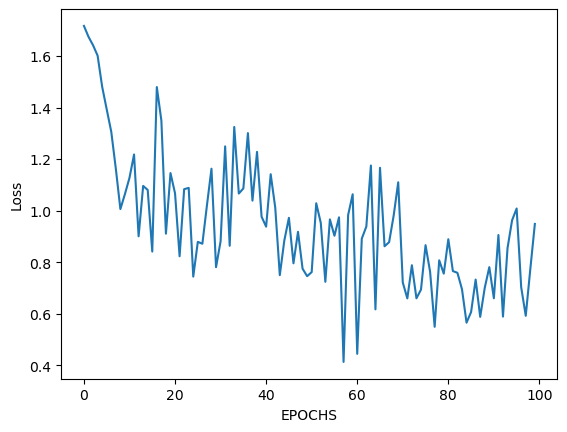

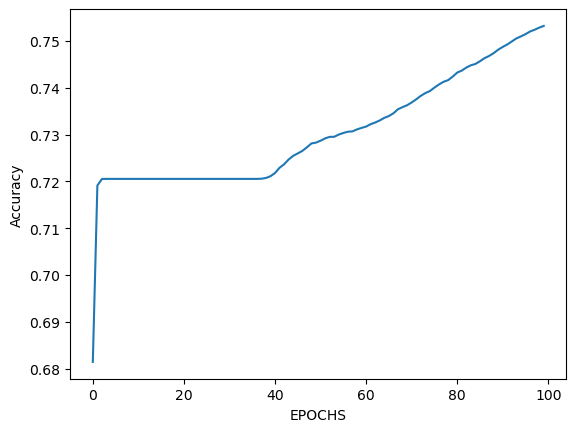

In [185]:
lossList = list(i.data.cpu().numpy().tolist() for i in epoch_loses)
accuracy = list(x for x,y in training_accuracies)
plot_curve(TRAINING_EPOCHS, lossList,"Loss",len(train_queries),format='svg')
plot_curve(range(TRAINING_EPOCHS), accuracy,"Accuracy",len(train_queries),format='svg')

In [189]:
model.eval()
perm = list(range(len(train_queries)))
start = 0
one_acc_num = 0

#while start < len(train_queries):
end = start + BATCH_SIZE if start + BATCH_SIZE < len(perm) else len(perm)

q_seq, col_seq, col_num, ans_seq, query_seq, ground_truth_cond_seq, raw_data = gen_batch_sequence(train_queries, train_tables, perm, start, end)


raw_q_seq = [x[0] for x in raw_data]
raw_col_seq = [x[1] for x in raw_data]

query_gt = []
table_id = []

for i in range(start, end):
        query_gt.append(train_queries[perm[i]]['sql'])
        table_id.append(train_queries[perm[i]]['table_id'])

ground_truth_sel_seq = [x[1] for x in ans_seq]
score = model.forward(q_seq, col_seq, )


B = len(q_seq)
agg_score = score[0]
ret_queries = []
cur_query = {}

agg_pred = np.argmax(agg_score.data.cpu().numpy(),axis = 1)
pred_queries = []
for i in range(len(agg_pred)):
    pred_queries.append({'agg':agg_pred[i]})
print(pred_queries)    
#get the ground truth queries.
# for b in range(B):
# #     print(agg_score.shape)
#     cur_query['agg'] = np.argmax(agg_score[b].data.cpu().numpy())
#     ret_queries.append(cur_query)
# pred_query = ret_queries
# tot_err = agg_err = 0.0
    
# one_err, tot_err = model.check_accuracy(pred_queries, query_gt)
# print(one_err, tot_err)

#print(pred_queries, )


[{'agg': 0}, {'agg': 0}, {'agg': 0}, {'agg': 0}, {'agg': 3}, {'agg': 0}, {'agg': 0}, {'agg': 3}, {'agg': 3}, {'agg': 0}, {'agg': 0}, {'agg': 0}, {'agg': 0}, {'agg': 0}, {'agg': 0}, {'agg': 0}, {'agg': 0}, {'agg': 0}, {'agg': 0}, {'agg': 3}, {'agg': 0}, {'agg': 0}, {'agg': 0}, {'agg': 0}, {'agg': 0}, {'agg': 0}, {'agg': 0}, {'agg': 0}, {'agg': 0}, {'agg': 0}, {'agg': 0}, {'agg': 0}, {'agg': 0}, {'agg': 0}, {'agg': 0}, {'agg': 0}, {'agg': 0}, {'agg': 0}, {'agg': 0}, {'agg': 0}, {'agg': 3}, {'agg': 3}, {'agg': 0}, {'agg': 3}, {'agg': 0}, {'agg': 0}, {'agg': 3}, {'agg': 0}, {'agg': 0}, {'agg': 0}, {'agg': 0}, {'agg': 3}, {'agg': 0}, {'agg': 0}, {'agg': 0}, {'agg': 0}, {'agg': 0}, {'agg': 0}, {'agg': 0}, {'agg': 0}, {'agg': 0}, {'agg': 0}, {'agg': 0}, {'agg': 0}, {'agg': 3}, {'agg': 0}, {'agg': 0}, {'agg': 0}, {'agg': 3}, {'agg': 0}, {'agg': 0}, {'agg': 0}, {'agg': 0}, {'agg': 3}, {'agg': 0}, {'agg': 0}, {'agg': 0}, {'agg': 0}, {'agg': 0}, {'agg': 0}, {'agg': 0}, {'agg': 0}, {'agg': 0}, {'a

In [192]:
pred_queries = np.argmax(agg_score.data.cpu().numpy(),axis = 1)
ret_queries = []
for b in range(B):
#     print(agg_score.shape)
    cur_query['agg'] = np.argmax(agg_score[b].data.cpu().numpy())
    ret_queries.append(cur_query)
    
ite_list = list(x['agg'] for x in ret_queries)    
print(f"Iteration answer\n{ite_list}")
print(f"Broadcast answer\n{ pred_queries.tolist()}")
print(f"Ground Truth\n{list(query_gt[x]['agg'] for x in range(len(query_gt)))}")


true_in_ite = len(list(x for x in range(len(query_gt)) if ret_queries[x]['agg'] == query_gt[x]['agg']))
true_in_brd = len(list(x for x in range(len(query_gt)) if pred_queries[x] == query_gt[x]['agg']))
print(f"\nTrue values in iteration: {true_in_ite}\nTrue values in broadcast: {true_in_brd}")

Iteration answer
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Broadcast answer
[0, 0, 0, 0, 3, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 0, 3, 0, 0, 3, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 3, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0]
Ground Truth
[0, 0, 0, 0, 3, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 3, 0, 1, 2, 0, 3, 0, 0, 0, 0, 3, 0, 0, 0, 2, 0, 0, 0, 0, 0,

In [193]:
bre_pred = pred_queries.tolist()
agg_score_list = agg_score.data.cpu().numpy().tolist()

for i in range(len(ite_list)):
    if ite_list[i] == bre_pred[i]:
        print("Both values are same")
    elif(agg_score_list[i][ite_list[i]] > agg_score_list[i][bre_pred[i]]):
        print("Iterator is correct")
    else:
        print("Iteration is wrog")

In [54]:
agg_list = list(query_gt[i]['agg'] == pred_query[i]['agg'] for i in range(len(query_gt)))
good_list = list(query_gt[i] for i in range(len(agg_list)) if agg_list[i] == True)
print(len(good_list)/len(query_gt))

0.0390625


In [55]:
for b, (pred_query, ground_truth_qry) in enumerate(zip(pred_query, query_gt)):
        good = True
        print(f"Item {b}:")
        agg_pred = pred_query['agg']
        agg_gt =  ground_truth_qry['agg']
        
        if(agg_pred != agg_gt):
            print(f"predicted {b} as wrong item")
            good = False
if good == False:
    tot_err += 1

Item 0:
predicted 0 as wrong item
Item 1:
predicted 1 as wrong item
Item 2:
predicted 2 as wrong item
Item 3:
predicted 3 as wrong item
Item 4:
predicted 4 as wrong item
Item 5:
predicted 5 as wrong item
Item 6:
predicted 6 as wrong item
Item 7:
predicted 7 as wrong item
Item 8:
predicted 8 as wrong item
Item 9:
predicted 9 as wrong item
Item 10:
predicted 10 as wrong item
Item 11:
predicted 11 as wrong item
Item 12:
predicted 12 as wrong item
Item 13:
predicted 13 as wrong item
Item 14:
predicted 14 as wrong item
Item 15:
predicted 15 as wrong item
Item 16:
predicted 16 as wrong item
Item 17:
predicted 17 as wrong item
Item 18:
predicted 18 as wrong item
Item 19:
predicted 19 as wrong item
Item 20:
predicted 20 as wrong item
Item 21:
predicted 21 as wrong item
Item 22:
predicted 22 as wrong item
Item 23:
predicted 23 as wrong item
Item 24:
predicted 24 as wrong item
Item 25:
predicted 25 as wrong item
Item 26:
predicted 26 as wrong item
Item 27:
predicted 27 as wrong item
Item 28:
pre

In [ ]:
def epoch_acc(model, batch_size, sql_data, table_data, save_results = False):
    model.eval()
    perm = list(range(len(sql_data)))
    start = 0
    one_acc_num = 0.0
    while start < len(sql_data):
        end = start + batch_size if start + batch_size < len(perm) else len(perm)

        q_seq, col_seq, col_num, ans_seq, query_seq, ground_truth_cond_seq, raw_data =\
            gen_batch_sequence(sql_data, table_data, perm, start, end)
        
        raw_q_seq = [x[0] for x in raw_data]
        raw_col_seq = [x[1] for x in raw_data]
        
        query_gt, table_ids = generate_batch_query(sql_data, perm, start, end)
        ground_truth_sel_seq = [x[1] for x in ans_seq]
        
        score = model.forward(q_seq, col_seq, )
        pred_queries = model.gen_query(score, q_seq, col_seq,
                                       raw_q_seq, raw_col_seq)
        one_err, tot_err = model.check_accuracy(pred_queries, query_gt)
        
        one_acc_num += (end - start - one_err)
        tot_acc_num += (end - start - tot_err)
        
        start = end
        
        return tot_acc_num/ len(sql_data), one_acc_num/len(sql_data)

In [202]:
torch.save(model.aggregator, "Trained_aggregator_03032023_100EP_FullWikiSQL.pt")